# Encoding

- Değişkenlerin temsil şekilleri ile ilgili değişiklik yapmak demektir. 

        * Label Encoding:
        - Encode etmek aşağıdaki gibi değişkenlere onları ifade edecek yeni değişkenler atamaktır.
        - Örneğin daha öncesinde string olan ifadeleri 0|1 şeklinde ifade ediyoruz. 


<p align="center" >    
    <img src = "label_encoding1.png" width= "300" />
</p>

       Eğitim durumu ile ilgili bir değişken tanımlanmış olsun, ve bu eğitim durumlarını encoding yöntemi ile yeniden sınıflandıracak olalım.  "Pre-School" en düşük eğitim seviyesi ike PhD en yüksek eğitim seviyesidir. Yani veri sadece kategorik değil aynı zamanda ordinaldir, kendi içinde sıralıdır. Dolayısıyla en düşük eğitim durumuna 0, en yüksek olana 5 demek doğru bir yaklaşımdır. 

<p align="center" >    
    <img src = "label_encoding2.png" width= "300" />
</p>

        Futbol takımları ile ilgili değişken tanımlanmış olsun. Burada bir takımın diğer takım üzerinde bir üstünlüğü bulunmamaktadır. Yani veri hem kategorik hem de nominal bir veri türüdür.

        Dolayısıyla verimizi eğitim örneğinde olduğu gibi sınıflamak doğru değildir. Bunun için **One Hot Encoding** kullanacağız. Bu terimi de notebook'un ilerleyen bölümlerinde açıklayacağız.

### Label Encoding & Binary Encoding

Eğer bir kategorik değişkenin 2 sınıfı varsa ve 0|1 şeklinde sınıflandırıyorsak buna "Binary Encoding", ikiden fazla sınıfı varsa "Label Encoding" demekteyiz. 


In [2]:
# Kütüphanelerimizi import ediyoruz;

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
# Önceden yazmış olduğumuz fonksiyonları tanımlayalım;

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [6]:
def load_application_train():
    data = pd.read_csv("datasets/application_train.csv")
    return data

def load():
    data = pd.read_csv("datasets/titanic.csv")
    return data

In [7]:
# Titanic veri setini çağırıyoruz;

df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [8]:
# Amacaımız buradaki kategorik değişkeni binary(label) encoding etmektir;
df["Sex"].head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [9]:
# "Sex" değişkenini 0|1 şeklinde iki sınıf halinde encode etmek istiyoruz. 
# Bu işlemi labelencoding metodi ile yapacağız. Daha sonra da fit transform metodu ile "Sex" değişkeninde dönüştüreceğiz. 

# "sex" değişkenini binary encode etmek için;

le = LabelEncoder() # LabelEncoder() nesnemizi getiriyoruz.

# Bu nesneyi fit_transform metodu ile "sex" değişkenine uygulamamız gerekmektedir.

le.fit_transform(df["Sex"])[0:5]

# Burada alfabetik sıraya göre bir değer atama işlemi yapılmaktadır. 
# Female'deki f harfi m'den önce geldiği için "Female" : 0, "Male" : 1 olara kodlanmıştır.

array([1, 0, 0, 0, 1])

In [12]:
# Hangisine 0 hangisine 1 verdiğimizi unuttuk diyelim, bunu öğrenmek için; inverse_transform metodu kullanıyoruz. 
le.inverse_transform([0,1])
# Görüldüğü üzere 0= female, 1= maledir. 

array(['female', 'male'], dtype=object)

In [14]:
# Kendi ihtiyaçlarımıza göre biçimlendirebilmek adına bir label encoding fonksiyonu yazacağız;
def label_encoder(dataframe, binary_col): #birinci argümanda dataframe, 2. argumanda binary bir kod
    labelencoder = LabelEncoder() # Label encodinge dönüştürüyoruz. 
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col]) # fit edip değiştiriyoruz eski verileri ,
    return dataframe

In [15]:
# Şimdi titanic verisini yeniden import edelim;

df = load()

In [17]:
# Yukarıdaki formülü uygulayacağız lakin elimizde yüzlerce değişken var ise bunu nasıl ölçekleyebiliriz;
# Bunu ölçekleyebilmek için binary sütunları seçebilmemiz gerekir,
# Elimizde yüzlerce değişken olunca ne yapacağız, bunun için iki sınıflı kategorik değişkenleri bulup bunu binary encodingden geçireceğiz; 

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2] #değişkenin stunlarında gez, integer ya da float değil ise ve number unique sayısı 2 olanları seç diyoruz. 

binary_cols

['Sex']

#### NOT ❗️
       
        Neden ".nunique kullandıkta  ".unique()" kullanmadık? 

        ".nunique()" metodu NaN ifadeleri bir sınıf olarak görmezken ".unique()" metodu NaN ifafdeleri bir sınıf olarak görür.

In [19]:
# Şimdi gözlemleyelim "Sex" değişkeni encode edilmiş mi;
for col in binary_cols:
    label_encoder(df, col)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.000,0,0,373450,8.050,NaN,S


In [20]:
# "Titanic" veri setinde encode edilmesi gereken tek bir değişken olduğu için bunu yapabildik. Peki daha büyük bir veri setinde bu işlem nasıl yapılacak?
# "application_train" veri setinde bakalım;

df = load_application_train()
df.shape

# 122 değişken olduğunu görüyoruz. 

(307511, 122)

In [21]:
# .head() ile binary değişken yapıp yapmayacağımızı anlamak çok zor.

df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.500,29686.500,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.000,21865.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000


In [23]:
# 122 değişkenden kaç tanesi kategorik değişken bunu sistematik bir şekilde anlamak için; 
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2] 
binary_cols
# 4 tanesi kategorikmiş. 

['NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'EMERGENCYSTATE_MODE']

In [24]:
# Yukardaki değişkenleri seçmek istersek; 
df[binary_cols].head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,Cash loans,N,Y,No
1,Cash loans,N,N,No
2,Revolving loans,Y,Y,NaN
3,Cash loans,N,Y,NaN
4,Cash loans,N,Y,NaN


In [26]:
# Şimdi bu veri setini döngüye sokalım;

for col in binary_cols:
    label_encoder(df, col)

df[binary_cols].head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,0,0,1,0
1,0,0,0,0
2,1,1,1,2
3,0,0,1,2
4,0,0,1,2


DİKKAT ❗️

"EMERGENCYSTATE_MODE" değişkenine bakıldığı zaman 2 ile gösterilen yerler tablonun ilk halinde "NaN" gözükmektedir. 

Yani kodumuz eksik verileri de kendisi doldurmuş. Bu durum için ne yapabiliriz?

1. Bir önceki bölümde eksik verileri düzeltebilirdik. 
2. Eksik verileri bu şekilde bırakabiliriz. (Şunu biliyor olmak lazım, 2 eksik değeri ifade etmektedir.)


## One Hot Encoding

In [ ]:
# Label encoding'e benzese de kategorik sınıflar arasında bir fark yok ise, 
# bunlar arasında bir sıralama oluşturmak bir fark oluşturmak bir ölçüm problemi oluşturabilir.

        Label encoding ölçüm problemi oluşturma potansiyeli taşıdığından, kategorik sınıflar arasında fark yoksa aşağıdaki gibi one hot encoding yapılır.

<p align="center" >    
    <img src = "one_hot_encoding.png" width= "800" />
</p>

In [ ]:
# Sınıfları değişkenlere dönüştürüyoruz. Örneğin gs sutünunda sadece gs satırına 1 diğerlerine 0 yazıyoruz. 

        One-hot encoding uygularken, kullanacak olduğumuz metodlarda dropfirst diyerek ilk sınıfı drop etmiş oluruz. Böylece dummy değişken tuzağından kurtuluruz. Dummy değişken tuzağı bir ölçme problemine yol açmaktadır. Bundan dolayı dummy değişken oluşturulurken ilk sınıf drop edilir. 

In [28]:
df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [30]:
df["Embarked"].value_counts()
# Embarked değişkeninin 3 sınıfı var, bu sınıflar arasında bir fark ya da sıralama yok. Nominal ölçek türüyle ölçülmüş kategorik bir değişken.
# Bunu one-hot encodingden geçireceğiz. 

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [31]:
pd.get_dummies(df, columns=["Embarked"]).head()
# get_dummies; sadece dönüştürmek istediğimiz(Embarked) değişkeni yazarak dönüştümemizi sağlar. 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,0,0,1


In [33]:
# Dummy değişken tuzağına düşmemek için drop_first argümanını true olarak değiştirmemiz gerekmektedir. 
pd.get_dummies(df,columns=["Embarked"], drop_first=True).head()
# Görüldüğü üzere ilk sınıf(Embarked_C) uçtu. Bunu ise alfabetik sıraya göre seçmektedir. 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,0,1


In [34]:
# Eksik değerler için de bir sınıf oluşturulsun istersek;

pd.get_dummies(df, columns=["Embarked"], dummy_na=True).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,0,0,1,0


In [35]:
# Label encoding(get_dummies metodu ile yalnızca binary encoding yapabilriz) ve one hot encodingi aynı anda encode edelim;

pd.get_dummies(df,columns=["Sex", "Embarked"],drop_first=True).head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.000,1,0,A/5 21171,7.250,NaN,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.000,1,0,PC 17599,71.283,C85,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.000,0,0,STON/O2. 3101282,7.925,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000,1,0,113803,53.100,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.000,0,0,373450,8.050,NaN,1,0,1


In [36]:
# Bu işlem için kendi fonksiyonumuzu yazalım; 
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe= pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


In [40]:
# df ve listelerimize bir reset atalım;
df= load()
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [41]:
# One Hot encoding yapacağımız sütunları bulalım;
# Bunun için nunique sayısının 2den büyük 10dan küçük ise bunları seç diyoruz;

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols

['Pclass', 'SibSp', 'Parch', 'Embarked']

In [42]:
# Fonksiyonumuzu bir üstteki satırda bulduğumuz sütunlarla birlikte kullanalım;

one_hot_encoder(df, ohe_cols).head()

,PassengerId,Survived,Name,Sex,Age,Ticket,Fare,Cabin,Pclass_2,Pclass_3,...,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",male,22.000,A/5 21171,7.250,NaN,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,PC 17599,71.283,C85,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",female,26.000,STON/O2. 3101282,7.925,NaN,0,1,...,0,0,0,0,0,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,113803,53.100,C123,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",male,35.000,373450,8.050,NaN,0,1,...,0,0,0,0,0,0,0,0,0,1


## Rare Encoding

        Ölçüm değeri taşıdığına inanmadığımız belirli bir eşik değerden daha az frekans gösteren verileri bir araya toplayarak yeni sınıf yapısı oluşturulmasına rare encoding denir.

        Aşağıdaki tabloya bakıldığındaa L şehri için bir sütun oluşturmanın mantığı tartışılabilir. Frekansı bir olan tek şehir için yüzlerce başka değişken değeri 0 olan bir sütun oluşurulmasını sorguluyoruz.

<p align="center" >    
    <img src = "rare_encoding.png" width= "800" />
</p>

Rare encoding 3 adımda yapılır;
1. Kategorik değişkenlerin azlık çokluk durumunun analiz edilmesi.
2. Rare kategoriler ile bağımlı değişken arasındaki ilişkinin analiz edilmesi.
3. Rare encoder fonksiyonunun yazılması.

### 1. Kategorik değişkenlerin azlık çokluk durumunun analiz edilmesi.

In [43]:
df= load_application_train()
df["NAME_EDUCATION_TYPE"].value_counts()
# Academic degree ve Lower secondary değişkenleri frekanslarını yeterince fazla olmadığı şeklinde yorumlayabiliriz.

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

In [44]:
# Kategorik değişkenlere erişmek istiyoruz. Bu sebeple df'teki kategorik değişkenleri getiriyoruz; 
cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols

Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39


['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'TARGET',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOC

In [46]:
# Daha önceden tanımlamış olduğumuz bir fonksiyonu tanımlayalım;
# Bu fonksiyon bize bir df içerisindeki kategorik değişkenlerin sınıflarını ve bu sınıfların oranlarını getirsin;

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [47]:
# Bütün kategorik değişkenler ve sınıfları, oranalrı geldi. 
# XNA sınıfı silinmeli, bir bilgi taşımamaktadır. 0.001 oranın bizim için anlamı yok. 
for col in cat_cols:
    cat_summary(df, col)

                 NAME_CONTRACT_TYPE  Ratio
Cash loans                   278232 90.479
Revolving loans               29279  9.521
##########################################
     CODE_GENDER  Ratio
F         202448 65.834
M         105059 34.164
XNA            4  0.001
##########################################
   FLAG_OWN_CAR  Ratio
N        202924 65.989
Y        104587 34.011
##########################################
   FLAG_OWN_REALTY  Ratio
Y           213312 69.367
N            94199 30.633
##########################################
                 NAME_TYPE_SUITE  Ratio
Unaccompanied             248526 80.819
Family                     40149 13.056
Spouse, partner            11370  3.697
Children                    3267  1.062
Other_B                     1770  0.576
Other_A                      866  0.282
Group of people              271  0.088
##########################################
                      NAME_INCOME_TYPE  Ratio
Working                         158774 51.632
C

In [48]:
cat_summary(df, "NAME_FAMILY_STATUS")

# Aşağıdaki verinin içerisinde bulunma oranı yüzbinde 1 olan "Unknown" sınıfı için bir label oluşturmak doğru bir yaklaşım olmayabilir.
# Bu "NAME_FAMILY_STATUS" değişkeni gibi bir çok değişken olduğunu görebiliyoruz.

                      NAME_FAMILY_STATUS  Ratio
Married                           196432 63.878
Single / not married               45444 14.778
Civil marriage                     29775  9.683
Separated                          19770  6.429
Widow                              16088  5.232
Unknown                                2  0.001
##########################################


In [49]:
len(cat_cols)

54

Yukarıda görüldüğü üzere 54 adet kategorik değişken var, biz bunların tamamını one hot encode edersek işimiz çok fazla zorlaşabilir. Amacımız karmaşık problemler çıkarmak değil, en basit modeli uygulamak.

### 2. Rare kategoriler ile bağımlı değişken arasındaki ilişkinin analiz edilmesi.

In [50]:

# Verinin bağımlı değişkeni target'dır ve 1 olması default'ı 0 olması ise kredilerin zamanında ödendiğini ifade eder.
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.500,29686.500,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.000,21865.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000


In [51]:
# Veri setimize ait "NAME_INCOME_TYPE" sütununu inceleyelim;

df["NAME_INCOME_TYPE"].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [56]:
# Bu sütunun meslek gruplarının kredileri ödeme durumunu oransal olarak kontrol edelim;
df.groupby("NAME_INCOME_TYPE")["TARGET"].mean()
 
# Değerin 1'e yaklaşması kredinin ödenmemesi anlamına gelmekteydi. 
# Businessman kategorisinde değer 0.000 görünüyor, bu da Businessmanlerin ödeme konusunda sıkıntı çekmediklerini gösteriyor. 
# Unemployed ve Maternity leave ödeyemediklerini görebiliyoruz. 

NAME_INCOME_TYPE
Businessman            0.000
Commercial associate   0.075
Maternity leave        0.400
Pensioner              0.054
State servant          0.058
Student                0.000
Unemployed             0.364
Working                0.096
Name: TARGET, dtype: float64

        Yukarıda "Businessman"lerin temerrüde düşmediklerini söylüyoruz lakin veri içerisindeki görülme frekansı 10, doğum iznindekiler hakkında bir çıkarımda bulunduk lakin veride yeterince temsil ediliyor mu sorusuna net bir cevap vermek pek de mümkün değil.

        Lakin bunlar arasında bir fark olduğu da açık, maternity leave olanlar ile business man olanlar arasında temerrüde düşme açısından da bir fark bulunuyor.

        Bunları aynı rare variable altında toplamak mantıklı mı bu soruyu da kendimize soruyor olacağız. Bunları aynı değişken altında toplamak da anlamlandırılma açısından bir noktaya varmayabilir ve veri setinde bir gürültü oluşuturuyor olabilir.

        Ama şimdilik biz aynı değişken (rare variable) altında topluyor olacağız. :)

In [58]:
# Verimizde nadir görülen sınıfları bulmak adına bir fonksiyon tanımlıyoruz;

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts())) # ilgili kategorik değişkenin kaç sınıfı var bilgisi
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(), # Sınıf frekansları
                            "RATIO": dataframe[col].value_counts() / len(dataframe), #Sınıf oranları
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n") # bağımlı değişkene göre (target) groupby işlemi

In [59]:
rare_analyser(df,"TARGET", cat_cols)
# Elimizdeki bütün kategorik değişkenlerin rare analizini yaptık. 
# DEF_60_CNT_SOCIAL_CIRCLE değişkenine bakalım. 9 sınıfı var, sınıfların frekansları, ornaları ve target açısından değerlerini görebiliyoruz. 
# Sınıfların %1 in altında olanlarını bir araya getirmeye karar veriyoruz. 

NAME_CONTRACT_TYPE : 2
                  COUNT  RATIO  TARGET_MEAN
Cash loans       278232  0.905        0.083
Revolving loans   29279  0.095        0.055


CODE_GENDER : 3
      COUNT  RATIO  TARGET_MEAN
F    202448  0.658        0.070
M    105059  0.342        0.101
XNA       4  0.000        0.000


FLAG_OWN_CAR : 2
    COUNT  RATIO  TARGET_MEAN
N  202924  0.660        0.085
Y  104587  0.340        0.072


FLAG_OWN_REALTY : 2
    COUNT  RATIO  TARGET_MEAN
N   94199  0.306        0.083
Y  213312  0.694        0.080


NAME_TYPE_SUITE : 7
                  COUNT  RATIO  TARGET_MEAN
Children           3267  0.011        0.074
Family            40149  0.131        0.075
Group of people     271  0.001        0.085
Other_A             866  0.003        0.088
Other_B            1770  0.006        0.098
Spouse, partner   11370  0.037        0.079
Unaccompanied    248526  0.808        0.082


NAME_INCOME_TYPE : 8
                       COUNT  RATIO  TARGET_MEAN
Businessman               10  0.

### 3. Rare encoder'ın yazılması.

In [61]:
# Rare encoder fonksiyonunu tanımlıyoruz;

def rare_encoder(dataframe, rare_perc):

    # Üzerinde değişiklik yapılacağından dolayı dataframe'mimizin bir kopyasını alalım.
    temp_df = dataframe.copy()

    # rare_columns listesi tanımlayalım ve yakalayacağımız rare değişkenleri bu listede tutalım.
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'    # değişkenin tipi object (kategorik) ise ve ...
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
                    # ... veri içerisinde görülme sıklığı belirlenen "rare_perc" oranından küçük grup barındıran değişkenlerin seçilme işlemi
                    # Yukarıda ".any()" metodu da bulunmaktadır, içinde var ise listeye almasını söylüyoruz.


    for var in rare_columns:    # içerisinde görülme sıklığı %1'in altıda grup barındıran rare column'larda gez,
        tmp = temp_df[var].value_counts() / len(temp_df) # Bu değişken/sütunlar içerisindeki grupların yüzdelerini hesapla,
        rare_labels = tmp[tmp < rare_perc].index    # Bu hesaplanan yüzdeler "rare_perc"ten küçük ise bunların indeksini al,
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var]) # indeksi alınan yerdeki değişkene rare yaz diyoruz.

    return temp_df

In [64]:
new_df = rare_encoder(df, 0.01)

rare_analyser(new_df, "TARGET", cat_cols)

NAME_CONTRACT_TYPE : 2
                  COUNT  RATIO  TARGET_MEAN
Cash loans       278232  0.905        0.083
Revolving loans   29279  0.095        0.055


CODE_GENDER : 3
       COUNT  RATIO  TARGET_MEAN
F     202448  0.658        0.070
M     105059  0.342        0.101
Rare       4  0.000        0.000


FLAG_OWN_CAR : 2
    COUNT  RATIO  TARGET_MEAN
N  202924  0.660        0.085
Y  104587  0.340        0.072


FLAG_OWN_REALTY : 2
    COUNT  RATIO  TARGET_MEAN
N   94199  0.306        0.083
Y  213312  0.694        0.080


NAME_TYPE_SUITE : 5
                  COUNT  RATIO  TARGET_MEAN
Children           3267  0.011        0.074
Family            40149  0.131        0.075
Rare               2907  0.009        0.094
Spouse, partner   11370  0.037        0.079
Unaccompanied    248526  0.808        0.082


NAME_INCOME_TYPE : 5
                       COUNT  RATIO  TARGET_MEAN
Commercial associate   71617  0.233        0.075
Pensioner              55362  0.180        0.054
Rare              

In [65]:
df["OCCUPATION_TYPE"].value_counts()
# buradaki değişkenleri de yukarıda bir araya getirdik. 

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

## Özellik Ölçeklendirme (Feature Scaling)

- Özellik ölçeklendirmedeki amaçlardan birisi değişkenler arasındaki ölçüm farklılıklarını gidermektir.
- Yani kullanılacak olan modellerin değişkenlere eşit şartlar altında yaklaşmasını sağlamaya çalışmaktır.

Diyelim ki elimizde 3 değişken olsun. Bu değişkenler, filmlere verilen puan, filmlere yapılan yorum ve filmlere 1 ile 10 arasındaki puanlar olsun. Bu 3 değişkenin dağılımları farklı oluğu için aynı etkiler açısından bir modelleme tekniğine gönderememekteyiz. (Ağaç yöntemleri istisnadır)

Değişkenlerin bu ölçekleri arasındaki farklılıklar, kullanıalacak olan algoritmada yanlılıklara sebep olabilmektedir. 

Dolyısıyla Before scaling kısmını after scalingde olduğu gibi ölçeklendirmemiz gerekmektedir. 

<p align="center" >    
    <img src = "feauture_scaling.png"/>
</p>

#### Standartlaştırma Metodları

#### Standard Scaler: Klasik standartlaştırma. 
- Ortalama bütüm gözlem değerlerinden çıkarılır ve standart sapmaya bölünür z = (x - u) / s

In [67]:
df = load()
# StandardScaler() nesnemizi getirip, fittransform ederek yaş değişkenimize uygulayalım. İlerde kıyaslama yapmak açısından ayrıca kaydedelim;
ss = StandardScaler()
df["Age_standart_scaler"] = ss.fit_transform(df[["Age"]])
df.head()
# Gözlemlenebildiği üzere en sağ tarafta bir standartlaştırma işlemi yapıldı. 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_standart_scaler
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,-0.530
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,0.572
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,-0.255
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,0.365
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0.365


In [ ]:
###################
# RobustScaler: Medyanı çıkar iqr'a böl.
# Yukarıda standartlaştırırken, ortalama da standart sapma da aykırı değerlerden etkilenen metrikler olduğu unutulmamalıdır.
# Robust'da medyandan iqr çıkartarak hem merkezi eğilim ölçülerini göz önünde bulunduruyoruz, hem de standarlaştırma işlemi yapıyoruz.
###################

#### Robust Scaler: 
- Bütün gözlem birimlerinden medyanı çıkarıp, iqr'a bölünür. 
- Yukarıda standartlaştırırken, ortalama da standart sapma da aykırı değerlerden etkilenen metrikler olduğu unutulmamalıdır.
- Robust'da medyandan iqr çıkartarak hem merkezi eğilim ölçülerini göz önünde bulunduruyoruz, hem de standarlaştırma işlemi yapıyoruz.
** Robust scaler standart scaler e göre aykırı değerlerden etkilenmemektedir. Ancak SS daha sık kullanılmaktadır. 

In [68]:
rs = RobustScaler()
df["Age_robuts_scaler"] = rs.fit_transform(df[["Age"]])
df.describe().T
# Dağılımın yapısında değil de ölçek olarak ifade ediliş tarzında bir değişiklik var. 


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.000,446.000,257.354,1.000,223.500,446.000,668.500,891.000
Survived,891.000,0.384,0.487,0.000,0.000,0.000,1.000,1.000
Pclass,891.000,2.309,0.836,1.000,2.000,3.000,3.000,3.000
Age,714.000,29.699,14.526,0.420,20.125,28.000,38.000,80.000
SibSp,891.000,0.523,1.103,0.000,0.000,0.000,1.000,8.000
Parch,891.000,0.382,0.806,0.000,0.000,0.000,0.000,6.000
Fare,891.000,32.204,49.693,0.000,7.910,14.454,31.000,512.329
Age_standart_scaler,714.000,0.000,1.001,-2.017,-0.660,-0.117,0.572,3.465
Age_robuts_scaler,714.000,0.095,0.813,-1.543,-0.441,0.000,0.559,2.909


#### MinMaxScaler: Verilen 2 değer arasında değişken dönüşümü
- X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
- X_scaled = X_std * (max - min) + min

In [70]:
mms = MinMaxScaler()
df["Age_min_max_scaler"] = mms.fit_transform(df[["Age"]])
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.000,446.000,257.354,1.000,223.500,446.000,668.500,891.000
Survived,891.000,0.384,0.487,0.000,0.000,0.000,1.000,1.000
Pclass,891.000,2.309,0.836,1.000,2.000,3.000,3.000,3.000
Age,714.000,29.699,14.526,0.420,20.125,28.000,38.000,80.000
SibSp,891.000,0.523,1.103,0.000,0.000,0.000,1.000,8.000
Parch,891.000,0.382,0.806,0.000,0.000,0.000,0.000,6.000
Fare,891.000,32.204,49.693,0.000,7.910,14.454,31.000,512.329
Age_standart_scaler,714.000,0.000,1.001,-2.017,-0.660,-0.117,0.572,3.465
Age_robuts_scaler,714.000,0.095,0.813,-1.543,-0.441,0.000,0.559,2.909
Age_min_max_scaler,714.000,0.368,0.183,0.000,0.248,0.347,0.472,1.000


In [71]:
# Yukarıdaki tabloda "Age_standard_scaler" değişkeni incelendiğinde ortalamanın 0 standart sapmanın ise 1 olduğunu görebiliyoruz.
# Yine "Age_robuts_scaler" değişkenine bakılırsa ortalama ve std. dev.'in değiştiğini görüyoruz.

# "Age_standard_scaler" ve "Age_robuts_scaler" kıyaslandığında "Age_robuts_scaler"ın min ve max değerleri arasındaki fark daha azdır. 
# Bu da aykırı değerlerden daha az etkilenmesinden kaynaklanmaktadır.

# "Age_min_max_scaler" değişkeninde ise min. değer 0 iken max. değer 1'dir.

In [72]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_standart_scaler,Age_robuts_scaler,Age_min_max_scaler
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,-0.530,-0.336,0.271
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,0.572,0.559,0.472
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,-0.255,-0.112,0.321
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,0.365,0.392,0.435
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0.365,0.392,0.435


In [73]:
# Sonuçları karşılaştırmak için, ilgili veri setinde içerisinde yaş ifadesini barındıran değişkenleri seçelim;
age_cols = [col for col in df.columns if "Age" in col]
age_cols

['Age', 'Age_standart_scaler', 'Age_robuts_scaler', 'Age_min_max_scaler']

In [74]:
# Aşağıda ilgili değişkenler için grafik çizdirecek bir fonksiyon tanımlayalım;
# num_summary fonksiyonu çeyreklik değerlerini gösterir ve histogram grafiğini oluşturur. 
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

count   714.000
mean     29.699
std      14.526
min       0.420
5%        4.000
10%      14.000
20%      19.000
30%      22.000
40%      25.000
50%      28.000
60%      31.800
70%      36.000
80%      41.000
90%      50.000
95%      56.000
99%      65.870
max      80.000
Name: Age, dtype: float64


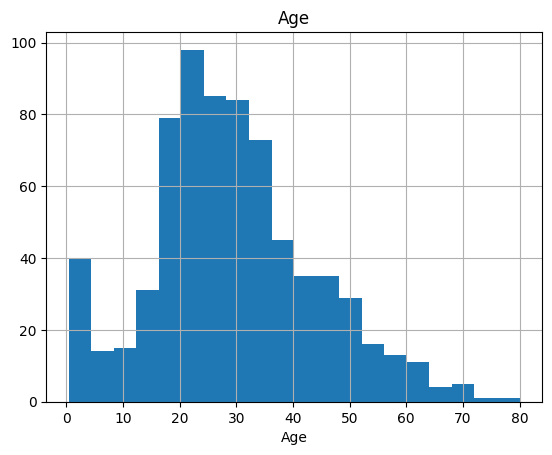

count   714.000
mean      0.000
std       1.001
min      -2.017
5%       -1.770
10%      -1.081
20%      -0.737
30%      -0.530
40%      -0.324
50%      -0.117
60%       0.145
70%       0.434
80%       0.778
90%       1.398
95%       1.812
99%       2.492
max       3.465
Name: Age_standart_scaler, dtype: float64


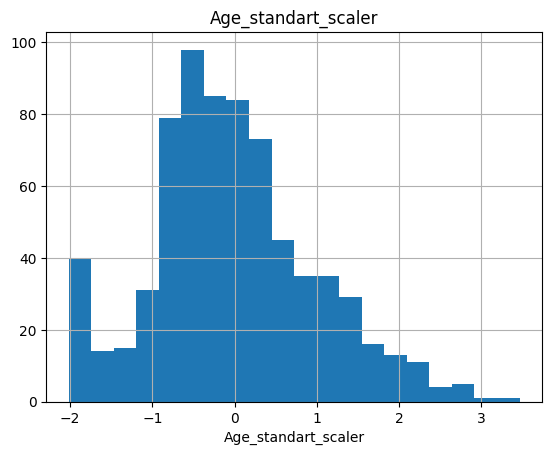

count   714.000
mean      0.095
std       0.813
min      -1.543
5%       -1.343
10%      -0.783
20%      -0.503
30%      -0.336
40%      -0.168
50%       0.000
60%       0.213
70%       0.448
80%       0.727
90%       1.231
95%       1.566
99%       2.119
max       2.909
Name: Age_robuts_scaler, dtype: float64


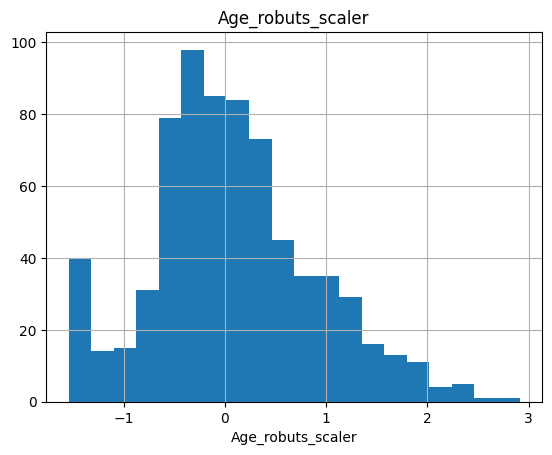

count   714.000
mean      0.368
std       0.183
min       0.000
5%        0.045
10%       0.171
20%       0.233
30%       0.271
40%       0.309
50%       0.347
60%       0.394
70%       0.447
80%       0.510
90%       0.623
95%       0.698
99%       0.822
max       1.000
Name: Age_min_max_scaler, dtype: float64


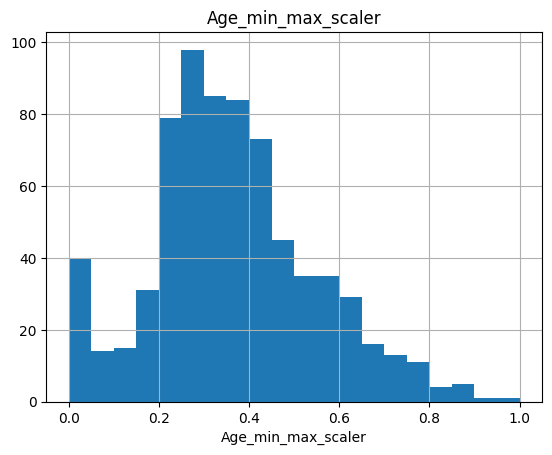

In [76]:
# Ortaya çıkan yeni değişkenlerin grafiğini çizdiriyoruz; 
for col in age_cols:
    num_summary(df, col, plot=True)

        Yukarıda görülmektedir ki değişkenler üzerinde uyguladığımız değişim dağılımı değiştirmemektedir.
        Yaptığımız işlem değişkenin yapısını bozmak değildir, yapısını koruyacak şekilde ifade ediliş tarzlarını değiştirme yani standartlaştırma işlemidir.

        Yani değişkenin taşıdığı bilgi bozulmamıştır.

### Numeric to Categorical: Sayısal Değişkenleri Kateorik Değişkenlere Çevirme/ Binning

In [78]:
df["Age_qcut"] = pd.qcut(df['Age'], 5, #labels = ...
)
df.head()

# böleceğimiz değişkenin etiketlerini biliyorsak, metod içerisine "label=" argümanı göndeririz.
# qcut() metodu bir değişkeni çeyrek değerlerine göre ayırır ve 5 parçaya böler. 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_standart_scaler,Age_robuts_scaler,Age_min_max_scaler,Age_qcut
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,-0.530,-0.336,0.271,"(19.0, 25.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,0.572,0.559,0.472,"(31.8, 41.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,-0.255,-0.112,0.321,"(25.0, 31.8]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,0.365,0.392,0.435,"(31.8, 41.0]"
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0.365,0.392,0.435,"(31.8, 41.0]"
